In [1]:
from __future__ import print_function
import datetime
import time
from functools import reduce
import os

import pyarrow.parquet as parquet
import pandas as pd
import numpy as np
%matplotlib nbagg
import matplotlib.pyplot as plt

from fastset import FastSet

In [2]:
# Data collected from a spark query at CERN, in pandas pickle format
# CRAB jobs only have data after Oct. 2017
ws = parquet.read_table('data/working_set_day').to_pandas()
# spark returns lists, we want to use sets
ws['working_set_blocks'] = ws.apply(lambda x: FastSet(x.working_set_blocks), 'columns')

In [3]:
#   DBS BLOCKS table schema:
#     BLOCK_ID NOT NULL NUMBER(38)
#     BLOCK_NAME NOT NULL VARCHAR2(500)
#     DATASET_ID NOT NULL NUMBER(38)
#     OPEN_FOR_WRITING NOT NULL NUMBER(38)
#     ORIGIN_SITE_NAME NOT NULL VARCHAR2(100)
#     BLOCK_SIZE NUMBER(38)
#     FILE_COUNT NUMBER(38)
#     CREATION_DATE NUMBER(38)
#     CREATE_BY VARCHAR2(500)
#     LAST_MODIFICATION_DATE NUMBER(38)
#     LAST_MODIFIED_BY VARCHAR2(500)
if not os.path.exists('data/block_size.npy'):
    # numpy readcsv couldn't handle the size :(
    blocksize = pd.read_csv("data/dbs_blocks.csv.gz", dtype='i8', usecols=(0,5), names=['block_id', 'block_size'])
    np.save('data/block_size.npy', blocksize.values)
    blocksize = blocksize.values
else:
    blocksize = np.load('data/block_size.npy')

# We'll be accessing randomly, make a fast lookup
bsort = np.argsort(blocksize[:,0])
bsize_index = blocksize[bsort, 0]
bsize_values = blocksize[bsort, 1]
def getsize(s):
    return bsize_values[np.searchsorted(bsize_index, s._set)].sum()

In [4]:
# join the data tier definitions
datatiers = pd.read_csv('data/dbs_datatiers.csv').set_index('id')
ws['data_tier'] = datatiers.loc[ws.d_data_tier_id].data_tier.values

In [5]:
date_index = np.arange(np.min(ws.day.values//86400), np.max(ws.day.values//86400)+1)
date_index_ts = np.array(list(datetime.date.fromtimestamp(day*86400) for day in date_index))

In [6]:
tic = time.time()

is_crab = ws.SubmissionTool=='crab3'
is_miniaod = ws.data_tier.str.contains('MINIAOD')
is_uc = ws.SiteName.str.match('T[23]_US_UC')
ws_filtered = ws[is_crab & is_miniaod & is_uc]

blocks_day = []
for i, day in enumerate(date_index):
    today = (ws_filtered.day==day*86400)
    blocks_day.append(reduce(FastSet.union, ws_filtered[today].working_set_blocks, FastSet()))

print("Done assembling blocklists")

nrecords = np.zeros_like(date_index)
lifetimes = {
    '1w': 7,
    '1m': 30,
    '3m': 90,
    '6m': 120,
}
ws_size = {k: np.zeros_like(date_index) for k in lifetimes}
nrecalls = {k: np.zeros_like(date_index) for k in lifetimes}
recall_size = {k: np.zeros_like(date_index) for k in lifetimes}
previous = {k: FastSet() for k in lifetimes}

for i, day in enumerate(date_index):
    nrecords[i] = ws_filtered[(ws_filtered.day==day*86400)].size
    for key in lifetimes:
        current = reduce(FastSet.union, blocks_day[max(0,i-lifetimes[key]):i+1], FastSet())
        recall = current - previous[key]
        nrecalls[key][i] = len(recall)
        ws_size[key][i] = getsize(current)
        recall_size[key][i] = getsize(recall)
        previous[key] = current
    if i%30==0:
        print("Day ", i)

elapsed = time.time() - tic
print("Done in %.1f seconds" % elapsed)

Done assembling blocklists
Day  0
Day  30
Day  60
Day  90
Day  120
Day  150
Day  180
Day  210
Day  240
Day  270
Day  300
Day  330
Day  360
Day  390
Day  420
Day  450
Day  480
Day  510
Day  540
Day  570
Day  600
Day  630
Day  660
Day  690
Day  720
Day  750
Day  780
Day  810
Day  840
Day  870
Day  900
Day  930
Day  960
Day  990
Day  1020
Day  1050
Day  1080
Done in 49.3 seconds


<IPython.core.display.Javascript object>


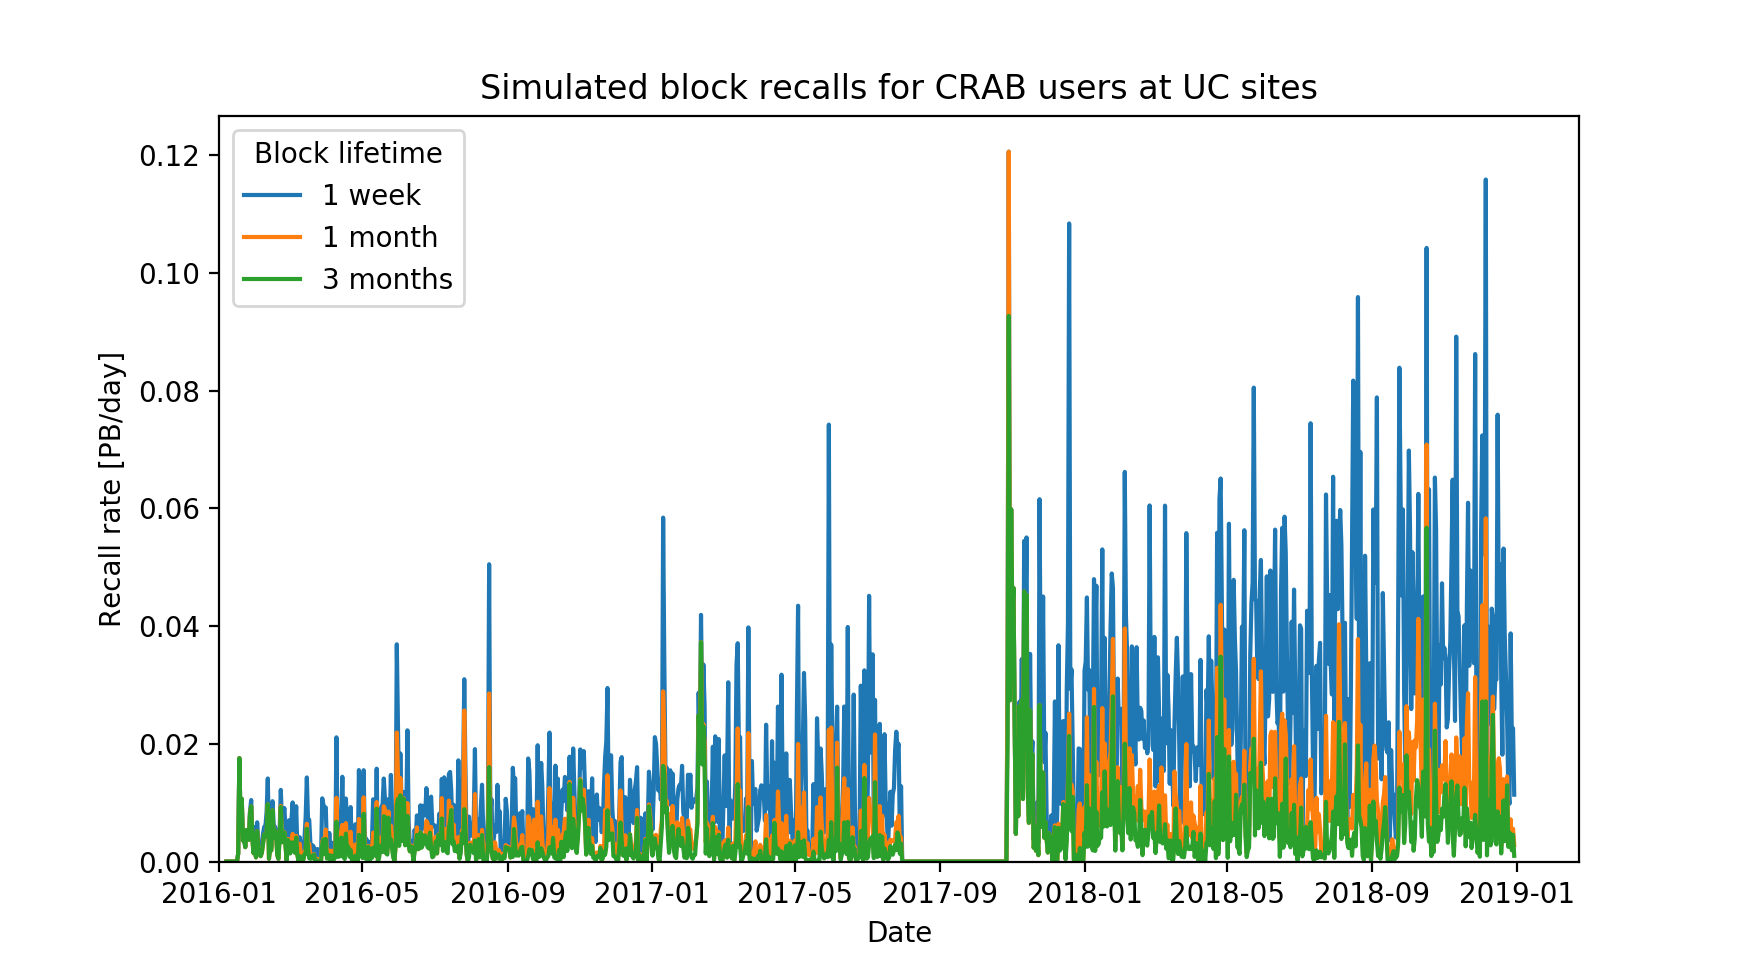

(735964.0, 737112.4)

In [7]:
fig, ax = plt.subplots(1,1)
ax.plot(date_index_ts, recall_size['1w']/1e15, label='1 week')
ax.plot(date_index_ts, recall_size['1m']/1e15, label='1 month')
ax.plot(date_index_ts, recall_size['3m']/1e15, label='3 months')
ax.legend(title='Block lifetime')
ax.set_title('Simulated block recalls for CRAB users at UC sites')
ax.set_ylabel('Recall rate [PB/day]')
ax.set_xlabel('Date')
ax.set_ylim(0, None)
ax.set_xlim(datetime.date(2016,1,1), None)

<IPython.core.display.Javascript object>


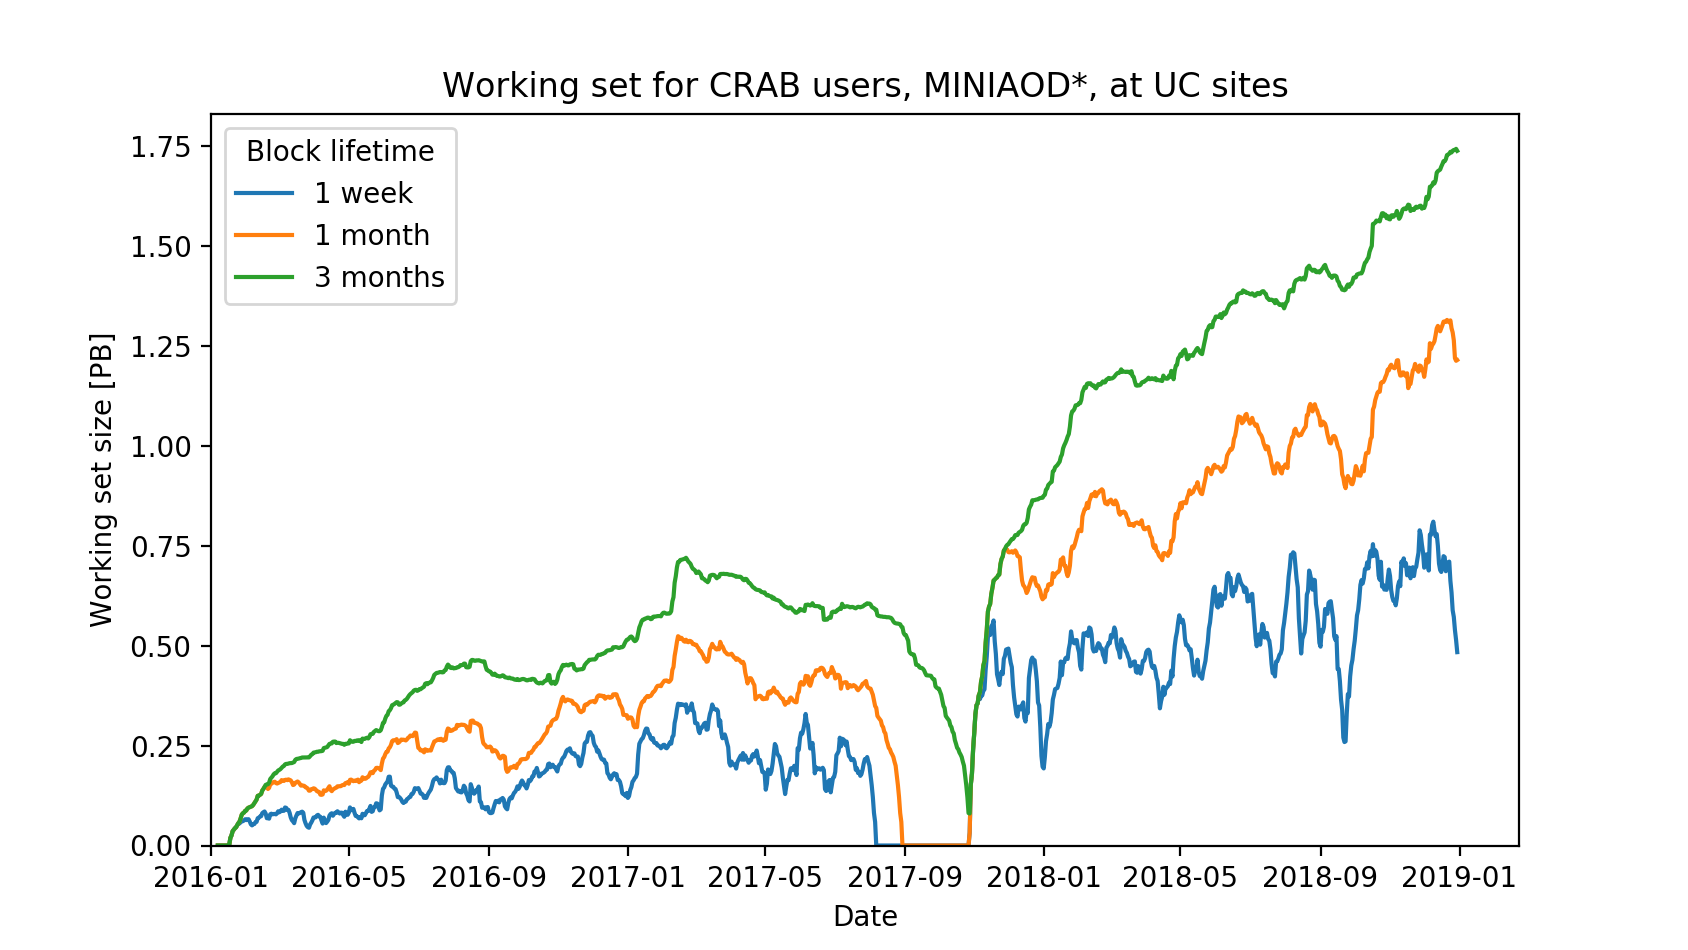

(735964.0, 737112.4)

In [8]:
fig, ax = plt.subplots(1,1)
ax.plot(date_index_ts, ws_size['1w']/1e15, label='1 week')
ax.plot(date_index_ts, ws_size['1m']/1e15, label='1 month')
ax.plot(date_index_ts, ws_size['3m']/1e15, label='3 months')
ax.legend(title='Block lifetime')
ax.set_title('Working set for CRAB users, MINIAOD*, at UC sites')
ax.set_ylabel('Working set size [PB]')
ax.set_xlabel('Date')
ax.set_ylim(0, None)
ax.set_xlim(datetime.date(2016,1,1), None)